# A simple agent simulation

## Bogumił Kamiński

### Genetic drift model

The idea of the model is as follows. On a rectangular grid we initially randomly put agents of two colors (I will use `true` and `false` to denote them). In one step we pick a random agent and change its type to the type of one of its neighbors. We will want to check, using simulation, if in the long run all agents end up having the same color and how long it takes, on the average, to reach this state.

A crucial design decision when modeling this problem is how we define neighbors of an agent. Some classical definitions are Moore or von Neumann neighborhoods on a torus.

In the experiment today I assume that if I have an agent in location `(x,y)` it has four neighbors on diagonals: `(x+1, y+1)`, `(x-1, y+1)`, `(x+1, y-1)`, `(x-1, y-1)`.

We assume the simulation is run on a torus, so left and right edge, and top and bottom edges of the grid are glued together.

I want to see what consequence this definition of the neighborhood has on the results of the simulation.

Let us start with an implementation on a grid of size 10 times 10 and plot the dynamics of the system. Here is the code running 30,000 steps of the simulation and want to see if we end up with all cells having the same type

In [1]:
using Random
using Plots

In [2]:
Random.seed!(1234)

TaskLocalRNG()

In [3]:
m = rand(Bool, 10, 10)

10×10 Matrix{Bool}:
 1  0  1  0  1  1  1  0  1  0
 0  0  1  0  1  0  0  0  1  1
 0  0  0  1  1  1  0  0  1  0
 1  0  0  1  1  0  0  0  1  1
 1  1  0  0  1  1  0  1  0  1
 1  1  0  1  1  1  1  1  1  1
 1  0  1  1  1  1  1  1  1  0
 1  0  1  1  0  0  0  0  1  1
 0  0  1  1  0  1  0  1  1  0
 1  0  0  1  0  1  1  0  1  1

In [4]:
anim = @animate for tick in 1:30_000
    x, y = rand(axes(m, 1)), rand(axes(m, 2))
    nx = mod1(x + rand((1, -1)), size(m, 1))
    ny = mod1(y + rand((1, -1)), size(m, 2))
    m[x, y] = m[nx, ny]
    heatmap(m, legend=false, size=(400, 400), title=tick)
end every 100

Animation("C:\\Users\\bogum\\AppData\\Local\\Temp\\jl_tTUVcq", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000291.png", "000292.png", "000293.png", "000294.png", "000295.png", "000296.png", "000297.png", "000298.png", "000299.png", "000300.png"])

[ Info: Saved animation to C:\WORK\dev\20024_Julia_StochasticSimulations\anim_fps15.gif


Plots.AnimatedGif("C:\\WORK\\dev\\20024_Julia_StochasticSimulations\\anim_fps15.gif")
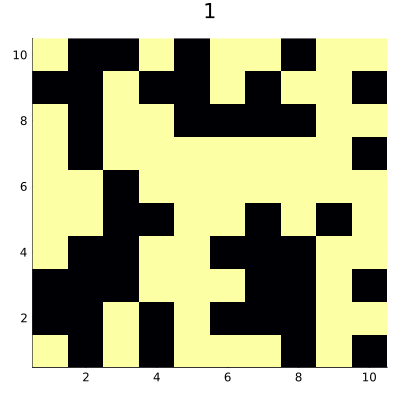

In [5]:
gif(anim, "anim_fps15.gif", fps=15)

Surprisingly, we reach a steady state that consists of 50% of true and 50% of false cells. This teaches us that one should be careful when designing ABM models, as small changes in the code can lead to significant changes it the behavior of the model.

The point is that our neighborhood consisting of four diagonal neighbors defines two disjoint sets of cells on a square having even size. In von Neumann neighborhood, which also consists of four negihbors (but top-down and left-right) we would not have such a problem.

Let us check. Start with creation of a neighborhood specification:

In [6]:
[(dx, dy) for dx in [-1, 0, 1], dy in [-1, 0, 1]]

3×3 Matrix{Tuple{Int64, Int64}}:
 (-1, -1)  (-1, 0)  (-1, 1)
 (0, -1)   (0, 0)   (0, 1)
 (1, -1)   (1, 0)   (1, 1)

In [7]:
vec([(dx, dy) for dx in [-1, 0, 1], dy in [-1, 0, 1]])

9-element Vector{Tuple{Int64, Int64}}:
 (-1, -1)
 (0, -1)
 (1, -1)
 (-1, 0)
 (0, 0)
 (1, 0)
 (-1, 1)
 (0, 1)
 (1, 1)

In [8]:
const VN_NEI = filter(!=((0, 0)), vec([(dx, dy) for dx in [-1, 0, 1], dy in [-1, 0, 1]]))

8-element Vector{Tuple{Int64, Int64}}:
 (-1, -1)
 (0, -1)
 (1, -1)
 (-1, 0)
 (1, 0)
 (-1, 1)
 (0, 1)
 (1, 1)

We used `const` to improve performance.

Now run a simulation (15,000 steps will be enough in this case).

[ Info: Saved animation to C:\WORK\dev\20024_Julia_StochasticSimulations\anim_fps15.gif


Plots.AnimatedGif("C:\\WORK\\dev\\20024_Julia_StochasticSimulations\\anim_fps15.gif")
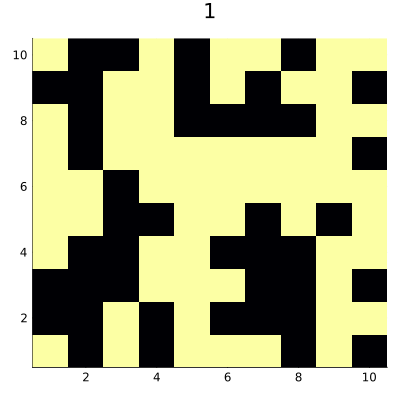

In [9]:
Random.seed!(1234)
m = rand(Bool, 10, 10)
anim = @animate for tick in 1:15000
    deltas = ()
    x, y = rand(axes(m, 1)), rand(axes(m, 2))
    dx, dy = rand(VN_NEI)
    nx, ny = mod1(x + dx, size(m, 1)), mod1(y + dy, size(m, 2))
    m[x, y] = m[nx, ny]
    heatmap(m, legend=false, size=(400, 400), title=tick)
end every 100
gif(anim, "anim_fps15.gif", fps=15)

Let us investigate our flawed model for different sizes of the grid.

Before we can do it we first need to think of some rule that detects that the simulation has reached a steady state and at the same time is cheap to check.

Note that if square grid edge size is odd we stop if all cells have the same state.
Note that if square grid edge size is even we stop if all cells have the same state in subgroups having an even and odd sum of locations.

We will use this fact to derive a cheap way to track simulation stopping condition.

In [10]:
function stop_condition(trues_even, trues_odd, d)
    if !(trues_even == 0 || trues_even == d^2 - div(d^2, 2))
        return false
    end
    if !(trues_odd == 0 || trues_odd == div(d^2, 2))
        return false
    end
    if isodd(d)
        if trues_even == 0 && trues_odd > 0
            return false
        end
        if trues_even > 0 && trues_odd == 0
            return false
        end
    end
    return true
end

function runsim(d)
    m = rand(Bool, d, d)
    trues_even = sum(m[i, j] for i in 1:d, j in 1:d if iseven(i + j))
    trues_odd = sum(m[i, j] for i in 1:d, j in 1:d if isodd(i + j))
    tick = 0
    while !stop_condition(trues_even, trues_odd, d)
        tick += 1
        x, y = rand(axes(m, 1)), rand(axes(m, 2))
        nx = mod1(x + rand((1, -1)), size(m, 1))
        ny = mod1(y + rand((1, -1)), size(m, 2))
        old = m[x, y]
        new = m[nx, ny]
        if old != new
            if iseven(x + y)
                if new
                    trues_even += 1
                else
                    trues_even -= 1
                end
            else
                if new
                    trues_odd += 1
                else
                    trues_odd -= 1
                end
            end
        end
        m[x, y] = new
    end
    class=sum(m) / d^2
    return (;d, tick, class)
end

runsim (generic function with 1 method)

Get some example results:

In [11]:
runsim(4)

(d = 4, tick = 189, class = 0.0)

In [12]:
runsim(5)

(d = 5, tick = 776, class = 1.0)

Now run experiment and collect the results in a data frame:

In [13]:
using DataFrames
using Statistics

In [14]:
@time df = DataFrame([runsim(d) for d in 4:12 for _ in 1:10_000])

 15.414257 seconds (324.21 k allocations: 33.503 MiB, 0.14% gc time, 1.43% compilation time)


Row,d,tick,class
,Int64,Int64,Float64
1,4,107,1.0
2,4,42,0.5
3,4,42,0.5
4,4,83,0.5
5,4,175,0.5
6,4,62,1.0
7,4,272,0.0
8,4,149,0.0
9,4,38,1.0


In [15]:
unstack(df, :d, :class, :tick, combine=mean)

Row,d,1.0,0.5,0.0
,Int64,Float64?,Float64?,Float64?
1,4,95.7156,97.7554,98.1811
2,5,510.248,missing,507.751
3,6,677.076,655.938,677.886
4,7,2310.58,missing,2314.18
5,8,2450.07,2474.82,2484.29
6,9,6995.02,missing,7023.63
7,10,6806.06,6691.33,6765.42
8,11,17391.7,missing,16965.8
9,12,15437.2,14709.7,15106.0


In [16]:
combine(groupby(df, [:d, :class], sort=true), nrow, :tick .=> [mean, std])

Row,d,class,nrow,tick_mean,tick_std
,Int64,Float64,Int64,Float64,Float64
1,4,0.0,2512,98.1811,67.3952
2,4,0.5,4935,97.7554,66.1784
3,4,1.0,2553,95.7156,64.7785
4,5,0.0,4954,507.751,401.652
5,5,1.0,5046,510.248,407.436
6,6,0.0,2517,677.886,440.057
7,6,0.5,5049,655.938,418.806
8,6,1.0,2434,677.076,430.57
9,7,0.0,5007,2314.18,1841.78


In [17]:
unstack(df, :d, :class, :tick, combine=x -> (mean(x), std(x)))

Row,d,1.0,0.5,0.0
,Int64,Tuple…?,Tuple…?,Tuple…?
1,4,"(95.7156, 64.7785)","(97.7554, 66.1784)","(98.1811, 67.3952)"
2,5,"(510.248, 407.436)",missing,"(507.751, 401.652)"
3,6,"(677.076, 430.57)","(655.938, 418.806)","(677.886, 440.057)"
4,7,"(2310.58, 1853.42)",missing,"(2314.18, 1841.78)"
5,8,"(2450.07, 1492.59)","(2474.82, 1552.25)","(2484.29, 1579.21)"
6,9,"(6995.02, 5323.75)",missing,"(7023.63, 5288.83)"
7,10,"(6806.06, 4390.76)","(6691.33, 4112.38)","(6765.42, 4375.21)"
8,11,"(17391.7, 13717.7)",missing,"(16965.8, 13324.3)"
9,12,"(15437.2, 9611.97)","(14709.7, 8872.83)","(15106.0, 9244.5)"


In [18]:
res = combine(groupby(df, :d, sort=true), :tick => mean)

Row,d,tick_mean
,Int64,Float64
1,4,97.3416
2,5,509.011
3,6,666.607
4,7,2312.38
5,8,2471.24
6,9,7009.62
7,10,6738.92
8,11,17178.5
9,12,14992.5


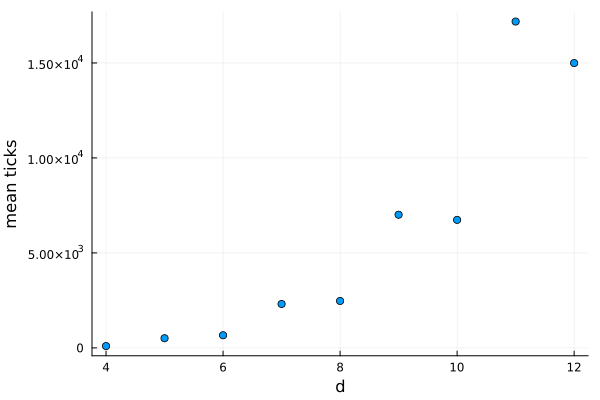

In [19]:
scatter(res.d, res.tick_mean, legend=nothing, xlab="d", ylab="mean ticks")